# Actionable Insights: Extracting Constructive Material from Customer Reviews
---

# PART 3: Clustering to Determine Categories and Trends

In this notebook, I will visualize the data and use a stack of machine learning models to categorize sentences extracted from reviews for Hubspot as actionable insights, or not, from the perspective of a Product Manager.  Product reviews can be an incredible resource for product managers, and companies as a whole, to measure customer satisfaction.  They can also be a window into features, bugs, and be incredibly informative to the direction of a product.  However, there is often a great deal of noise to be found in the reviews that will not be as informative.  Successful apps can have millions of reviews, and sifting through them can be overwhelming.  

To categorize the sentences as actionable or not I will compare a stack of models:

- Multi Layer Perceptron (MLP)
- Convolution Neural Network (CNN)
- Long Short Term Memory Neural Network (LSTM)

To improve upon these models I utilized Baysian hyperparameter optimization. 

I will use several techniques to determine if subcategories exist within the actionable sentences, including:

- HDBSCAN
- Tensorboard Clustering

Each sentence in the reviews has been vectorized with a 300 dimension vector.  This will be visualized by reducing those dimensions down to 2 and 3 dimensional space, and we will see if clustering occurs into natural subcategories within the actionable data. 

### CONTENTS

- [Import Libraries](#Import-Libraries)
- [Load in Data](#Load-in-Data)
- [Modeling for Actionable Insights](#Modeling-for-Actionable-Insights)
    - [MLP Model](#MLP-Model)
    - [LSTM Model](#LSTM-Model)
    - [CNN Model](#CNN-Model)
    - [Bayesian Hyperparameter Optimization](#Bayesian-Hyperparameter-Optimization)
- [Visualizing Actionable Data](#Visualizing-Actionable-Data)   
    - [Spacy Scattertext](#Spacy-Scattertext)
    - [Visualizing Empath Topics](#Visualizing-Empath-Topics)
- [Modeling for Sub-Categorization](#Modeling-for-Sub-Categorization)
    - [HDBSCAN](#HDBSCAN)
    - [2D visualization of Clustering](#2D-visualization-of-Clustering)
- [Tensorboard Projector Visualization](#Tensorboard-Projector-Visualization)

## Import Libraries

In [80]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import datetime

# Plot Formatting
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

# NLP libraries
import spacy
import en_core_web_md
from spacy.tokens import Span, Doc, Token
import scattertext as st

# Modeling libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import hdbscan

# Neural network libraries
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Embedding, Dropout, Dense, Activation, LSTM, Concatenate,SpatialDropout1D
from tensorflow.keras.layers import Input, Bidirectional, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorboard import notebook
from tensorboard.plugins import projector
import tensorflow.compat.v1 as tfc
from hyperopt import tpe, rand, Trials, fmin,hp

## Load in Data

In [3]:
G2 = pd.read_pickle('../Data/G2_labeled.pkl')
# G2_train = pd.read_pickle('../Data/G2_train.pkl')

### Let's establish a baseline.  

In [4]:
G2['Actionable'].value_counts(normalize=True)

0    0.71026
1    0.28974
Name: Actionable, dtype: float64

28.974% of sentences are labeled as actionable.

## Modeling for Actionable Insights

In [37]:
X = list(G2['vector'])
Y = np.asarray(G2['Actionable'])

In [38]:
# X = G2_train.loc[:,'v_0':]
# Y = G2_train.loc[:,"Actionable":'wishes']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)

We can log the results of the models with the CSV logger callback.

In [40]:
# Saves the model metrics in a log
csv_logger = CSVLogger('training.log', separator=',' ,append=True)

ss=StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [41]:
def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        
# 1-D Convolutional Neural Network        
    elif architecture == 'cnn':
        inputs = Input(shape=(300,1))
        x = Conv1D(64, 3, strides=1, padding='same', activation='relu',
                   kernel_regularizer=regularizers.l2(0.01))(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu', 
                   kernel_regularizer=regularizers.l2(0.01))(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='CNN')
        
# LSTM network        
    elif architecture == 'lstm':
        inputs = Input(shape=(300,1))
        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

### MLP Model
I'll start with a Multi-Layer Perceptron MLP model, a relatively simple but faster model, to get a sense of improvement over baseline.

In [83]:
# Logging Results
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [86]:
# Define Model
model = build_model('mlp')

# Compile Model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])

# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(Z_train, y_train,
                      validation_data=(Z_test,y_test),
                      epochs=epochs, batch_size=128, verbose=1, callbacks=[tensorboard_callback])

Train on 15650 samples, validate on 5217 samples
Epoch 1/50
15616/15650 [============================>.] - ETA: 0s - loss: 0.5494 - acc: 0.7313

TypeError: An op outside of the function building code is being passed
a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: dense_5/kernel:0

In [43]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 99.18% / Validation accuracy: 92.20%


In [45]:
# Plot model accuracy over epochs

def plot_epochs(estimator=estimator, model=estimator.model.name):
    """
    plots the accuracy and loss over epochs

    estimator = model from which to pull .history
    model = string of the name of the model.  model.name (default) will
    also work.

    """
    # Plot model accuracy over epochs
    plt.figure(figsize=(10,8))
    plt.plot(estimator.history['acc'])
    plt.plot(estimator.history['val_acc'])
    plt.title(f'{model} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

    # Plot model loss over epochs
    plt.figure(figsize=(10,8))
    plt.plot(estimator.history['loss'])
    plt.plot(estimator.history['val_loss'])
    plt.title(f'{model} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

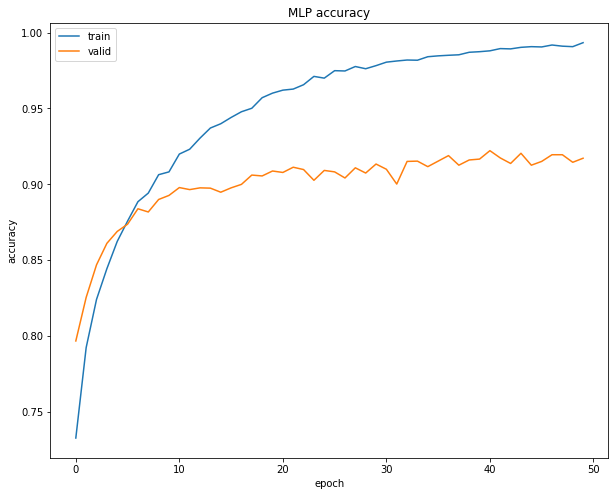

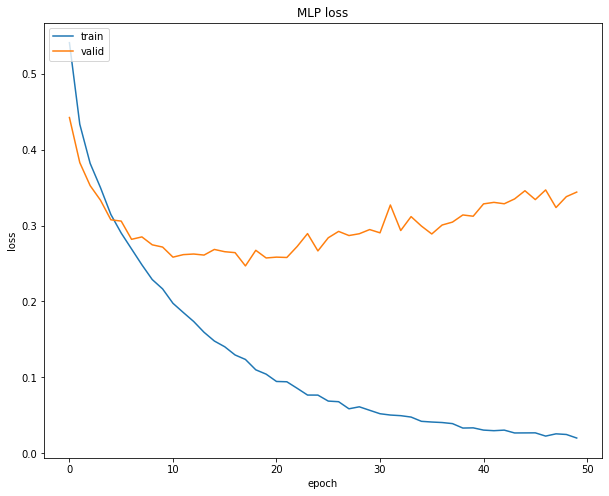

In [0]:
plot_epochs(model='MLP')

### LSTM Model
My thought is that the Long Short Term Memory Model will provide the best predictions for this NLP Classification challenge.

In [34]:
# Define model
# Using MLP in kernel for speed
# model = build_model('mlp')
# model = build_model('cnn')
model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    Zd_train = np.expand_dims(Z_train, axis=2)
    Zd_test = np.expand_dims(Z_test, axis=2)

In [35]:
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])

In [36]:
# Define number of epochs
epochs = 25

# Fit the model to the training data
estimator = model.fit(Zd_train, y_train,
                      validation_data=(Zd_test,y_test),
                      epochs=epochs, batch_size=128, verbose=1, callbacks=[csv_logger])

ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, <class 'pandas.core.series.Series'>

In [0]:

print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 88.88% / Validation accuracy: 86.31%


In [0]:
plot_epochs()

NameError: ignored

### CNN Model

In [0]:
model = build_model('cnn')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    Zd_train = np.expand_dims(Z_train, axis=2)
    Zd_test = np.expand_dims(Z_test, axis=2)

# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])

# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(Zd_train, y_train,
                      validation_data=(Zd_test,y_test),
                      epochs=epochs, batch_size=128, verbose=1, callbacks=[csv_logger])

Train on 15650 samples, validate on 5217 samples
Epoch 1/50
15650/15650 [==============================] - 2s 136us/sample - loss: 1.2951 - acc: 0.7098 - val_loss: 1.1305 - val_acc: 0.7117
Epoch 2/50
15650/15650 [==============================] - 2s 108us/sample - loss: 1.0148 - acc: 0.7098 - val_loss: 0.9166 - val_acc: 0.7117
Epoch 3/50
15650/15650 [==============================] - 2s 110us/sample - loss: 0.8458 - acc: 0.7098 - val_loss: 0.7876 - val_acc: 0.7117
Epoch 4/50
15650/15650 [==============================] - 2s 108us/sample - loss: 0.7438 - acc: 0.7098 - val_loss: 0.7100 - val_acc: 0.7117
Epoch 5/50
15650/15650 [==============================] - 2s 108us/sample - loss: 0.6822 - acc: 0.7098 - val_loss: 0.6632 - val_acc: 0.7117
Epoch 6/50
15650/15650 [==============================] - 2s 109us/sample - loss: 0.6449 - acc: 0.7098 - val_loss: 0.6349 - val_acc: 0.7117
Epoch 7/50
15650/15650 [==============================] - 2s 110us/sample - loss: 0.6223 - acc: 0.7098 - val_lo

In [0]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 71.00% / Validation accuracy: 71.17%


In [0]:
model.name
estimator.

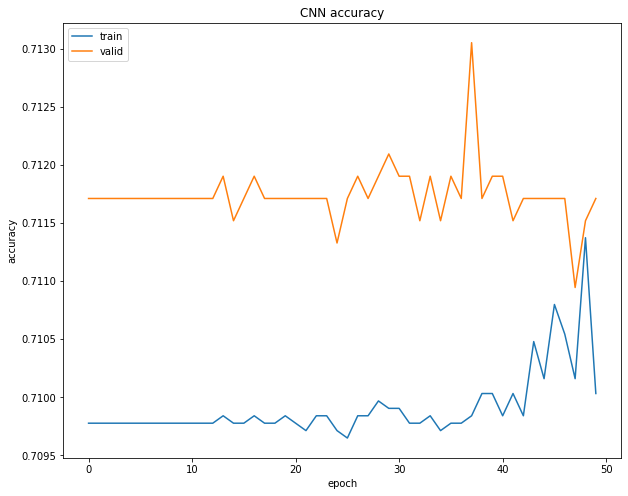

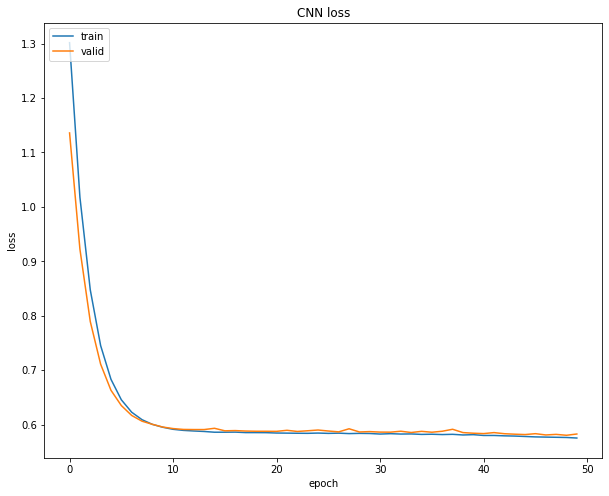

In [0]:
plot_epochs()

The CNN did not perform well, with accuracy scores very close to the baseline.  

## Bayesian Hyperparameter Optimization

In [0]:
# Initializeing Trials to record the performance of the optimization
tpe_trials=Trials()
rand_trials=Trials()

In [0]:
# Establishing X and Y parameters
X = list(G2['vector'])
Y = G2['Actionable']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=42)
csv_logger = CSVLogger('training.log', separator=',' ,append=True)

# Scaling the data
ss=StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

Below we see the same models previously tested with hyper parameters over which we will iterate in the baysian optimization.

In [0]:

# The objective function establishes the models and to be tested
def objective_func(args):
    model = Sequential()
    if args['model']=='MLP':
        neurons_layer_1 = args['param']['neurons_layer_1']
        neurons_layer_2 = args['param']['neurons_layer_2']
        neurons_layer_3 = args['param']['neurons_layer_3']
        neurons_layer_4 = args['param']['neurons_layer_4']
        reg=args['param']['reg']
        dropout_1 = args['param']['dropout_1']
        dropout_2 = args['param']['dropout_2']
        
        model.add(Dense(neurons_layer_1, activation='relu', kernel_initializer='he_normal', input_dim=300, kernel_regularizer=regularizers.l2(reg)))
        model.add(Dropout(dropout_1))
        model.add(Dense(neurons_layer_2, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dropout(dropout_2))
        model.add(Dense(neurons_layer_3, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dropout(dropout_1))
        model.add(Dense(neurons_layer_4, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg)))
        model.add(Dropout(dropout_2))
        model.add(Dense(1, activation='sigmoid'))
    elif args['model']=='CNN':
        CNN_neurons_layer_1 = args['param']['CNN_neurons_layer_1']
        CNN_neurons_layer_2 = args['param']['CNN_neurons_layer_2']
        reg_1=args['param']['reg_1']
        reg_2=args['param']['reg_2']
        pool_size = args['param']['pool_size']
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(300,1))
        x = Conv1D( CNN_neurons_layer_1, 3, strides=1, padding='same',  activation='relu',kernel_regularizer=regularizers.l2(reg_1))(inputs)
        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=pool_size)(x)
        x = Conv1D(CNN_neurons_layer_2, 3, strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(reg_2))(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif args['model'] == 'lstm':
        lstm_neurons_layer_1 = args['param']['lstm_neurons_layer_1']
        lstm_neurons_layer_2 = args['param']['lstm_neurons_layer_2']
        lstm_dropout_1 = args['param']['lstm_dropout_1']
        recurrent_reg=args['param']['recurrent_reg']

        inputs = Input(shape=(300,1))
        x = Bidirectional(
            # Use CuDNNLSTM for optimum performance on GPU, If No GPU, us LSTM
            CuDNNLSTM(  
            #LSTM(
                lstm_neurons_layer_1 , return_sequences=True,  recurrent_regularizer=recurrent_reg ),merge_mode='concat')(inputs)
        x = Dropout(lstm_dropout_1)(x)
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='LSTM')

    
    
    # Compile Model
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True  )
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['acc'])
    epochs = 15  
    
    
    # Fit the model to the training data
    if model.name == "CNN" or model.name == "LSTM":
        Zd_train = np.expand_dims(Z_train, axis=2)
        Zd_test = np.expand_dims(Z_test, axis=2)
        estimator = model.fit(Zd_train, y_train,
                      validation_data=(Zd_test,y_test),
                      epochs=epochs, batch_size=128, verbose=0, callbacks=[tensorboard_callback])
    else:
        estimator = model.fit(Z_train, y_train,
                      validation_data=(Z_test,y_test),
                      epochs=epochs, batch_size=128, verbose=0, callbacks=[tensorboard_callback])
    print("Model:", model.name)
    print("Test Score:",estimator.history['val_acc'][-1])
    print("Train Score:",estimator.history['acc'][-1])
    print("\n=================")
    return estimator.history['val_loss'][-1]

# This establishes the range of yperparameter values over which we will test our models
space = hp.choice('model',[
        {'model': 'MLP',
        'param': {
        'neurons_layer_1': hp.choice('neurons_layer_1',[64,256,512]),
        'neurons_layer_2': hp.choice('neurons_layer_2',[128,256,512]),
        'neurons_layer_3': hp.choice('neurons_layer_3',[64,128,512]),
        'neurons_layer_4': hp.choice('neurons_layer_4',[64,128,512]),
        'reg':hp.choice('reg', [0.001,0.01,0.1]),
        'dropout_1':hp.choice('dropout_1',[0.2,0.5,0.7]),
        'dropout_2':hp.choice('dropout_2',[0.2,0.5,0.7])
        }
        },
        {'model': 'CNN',
        'param': {
        'CNN_neurons_layer_1': hp.choice('CNN_neurons_layer_1',[64,256,512]),
        'CNN_neurons_layer_2': hp.choice('CNN_neurons_layer_2',[128,256,512]),
        'reg_1':hp.choice('reg_1', [0.0001 ,0.01,0.1]),
        'reg_2':hp.choice('reg_2', [0.001 ,0.01,0.1]),
        'pool_size':hp.choice('pool_size',[2,3,4])
        }}
        ,
        {'model': 'lstm',
        'param': {
        'lstm_neurons_layer_1': hp.choice('lstm_neurons_layer_1',[64,256,512]),
        'lstm_neurons_layer_2': hp.choice('lstm_neurons_layer_2',[32,64,128]),
        'lstm_dropout_1':hp.choice('lstm_dropout_1',[0.2,0.5,0.7]),
        'recurrent_reg':hp.choice('recurrent_reg',[None,regularizers.l2(0.01)]),
        }}
        ]);


### Running the Baysian Hyperparameter Optimization

In [0]:
# Using the Tree Parzan Estimator algorithm for optimization
best_tpe_model=fmin(objective_func,space,
                    algo=tpe.suggest,     # Tree Parzan Estimation
                    max_evals=100,         # Max number of iterations
                    trials=tpe_trials);   # Name of trials object 

# The trials database now contains 100 entries, it can be saved/reloaded with pickle
pickle.dump(trials, open("reviews.p", "wb"));
trials = pickle.load(open("reviews.p", "rb"));


Model:
LSTM
Test Score:
0.84857196
Train Score:
0.86741215

Model:
LSTM
Test Score:
0.8493387
Train Score:
0.86089456

Model:
CNN
Test Score:
0.7117117
Train Score:
0.70977634

Model:
sequential_28
Test Score:
0.90626794
Train Score:
0.9377636

Model:
CNN
Test Score:
0.7117117
Train Score:
0.70977634

 12%|█▎        | 5/40 [21:07<2:37:28, 269.95s/it, best loss: 0.34563277167951284]WARNING:tensorflow:Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Model:
LSTM
Test Score:
0.85393906
Train Score:
0.8598083

Model:
CNN
Test Score:
0.7120951
Train Score:
0.7100958

 18%|█▊        | 7/40 [37:35<3:08:04, 341.95s/it, best loss: 0.34563277167951284]WARNING:tensorflow:Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
Model:
LSTM
Test Score:
0.8504888
Train Score:
0.8632588

Model:
sequential_33
Test Score:
0.7117117
Trai

In [0]:
def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(300,1))

        x = Conv1D(128, 3, strides=1, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01))(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(64, 3, strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(300,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

In [0]:
# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))
print(tpe_best)

In [0]:
def model_func(layer_1_neurons,layer_2_neurons, drop_1, rc_drop):
    model=Sequential()
    model.add(Bidirectional(LSTM(layer_1_neurons,dropout=0.2, 
                   recurrent_dropout=rc_drop, 
                   input_shape=(300,1,),
                   activation='relu',
                   return_sequences=True),
                   merge_mode='concat'
                           ))
    model.add(SpatialDropout1D(drop_1))
    model.add(Dense(layer_2_neurons, activation='relu'))
    model.add(Flatten())
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

nn = KerasClassifier(build_fn=model_func,
                    batch_size=100,
                    verbose=0
                    )
# Set up params
params= {
    'epochs'         : [100,200,300],
    'layer_1_neurons': [32,128,256],
    'layer_2_neurons': [32,128,256],
    'drop_1'         : [0.2,0.5],
    'rc_drop'        : [0.2,0.5]
}

# GridSearch
gs = GridSearchCV(nn,param_grid=params, cv=3)
gs.fit(Zd_train,y_train)
print(gs.best_score_)
gs.best_params_

KeyboardInterrupt: 

In [0]:
nn.fit(Z_train,y_train)

In [0]:
embed = Embedding(462,
                  300, 
                  input_length=X.shape[1],
                  trainable=True)
lstm = LSTM(300, 
            dropout=0.3,
            recurrent_dropout=0.3
           )(embed)

# Adding labels into model after embeddings
labels = Input(shape=(G2_train.shape[0],11))
conc = Concatenate()(lstm, labels)
drop = Dropout(0.6)(conc)
dens = Dense(1)(drop)
acti = Activation('sigmoid')(dens)

model = Model([embed, label],acti)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])


AttributeError: 'Embedding' object has no attribute 'shape'

# Visualizing Actionable Data

## Spacy Scattertext
Scattertext visualizes the word vectors most frequently associated with either of our primary labels.

In [0]:
G2['parsed'] = G2['sentence'].progress_apply(nlp)

AttributeError: ignored

In [0]:

nlp = spacy.load('en',disable_pipes=["tagger","ner"])
G2_sent['parsed'] = G2_sent['sentence'].astype(str).apply(nlp)

In [0]:
corpus = st.CorpusFromParsedDocuments(G2,
                             category_col='label',
                             parsed_col='parsed').build()

KeyError: ignored

In [0]:
html = st.produce_scattertext_explorer(corpus,
          category='actionable',
          category_name='Actionable',
          not_category_name='Not_Actionable',
          width_in_pixels=600,
          minimum_term_frequency=10,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior()
          )

In [0]:
filename = "xG2_actionable_word_scatter.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

## Visualizing Empath Topics
This visualizes the text over empath categories instead of text.

In [0]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(G2_sent,
                                              category_col='label',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='parsed').build()

In [0]:
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='actionable',
                                        category_name='is_actionable',
                                        not_category_name='not_actionable',
                                        width_in_pixels=700,
                                        metadata=G2_sent['is_actionable'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())

In [0]:
from IPython.display import IFrame
from IPython.display import display, HTML

filename = "G2_empath_words.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 900, height=700)

# Modeling for Sub-Categorization

## HDBSCAN


In [0]:
X=list(G2['vector'])
Y = G2.loc[:,"Actionable":'wishes']

In [0]:
type(G2_train['vector'])

pandas.core.series.Series

In [0]:
clusterer = hdbscan.HDBSCAN(
        algorithm='boruvka_kdtree'
       ,alpha=1.0
       ,approx_min_span_tree=True
       ,gen_min_span_tree=True
       ,leaf_size=12
#        ,memory=Memory(cachedir=None)
       ,metric='euclidean'
       ,min_cluster_size=10
       ,prediction_data=True
       ,min_samples=None
       ,p=None
)

In [0]:
clusterer.fit(X)

HDBSCAN(algorithm='boruvka_kdtree', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=12,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
        prediction_data=True)

In [0]:
# G2_sent['clusters']=
clusterer.labels_

array([-1, -1,  8, ..., -1, -1, -1])

In [0]:
len(clusterer.labels_)

20866

In [0]:
clusterer.outlier_scores_

The outlier scores are a numpy array with a value for each sample in the original dataset that was fit with the clusterer. The higher the score, the more likely the point is to be an outlier. In practice it is often best to look at the distributions of outlier scores.

## 2D visualization of Clustering
### Using Dimensional Reduction with TSNE to visualize 300 dimension vectors in 2D

In [0]:
projection = TSNE().fit_transform(X)

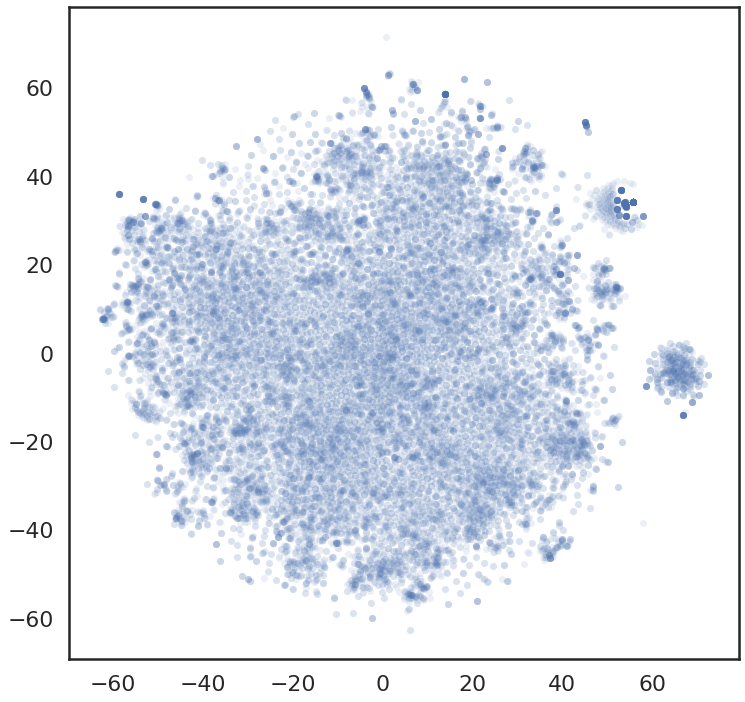

In [0]:
plt.figure(figsize=(12,12))
plt.scatter(*projection.T, s=50, linewidth=0, c='b', alpha=0.1);

In [0]:
set(clusterer.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

We can see here that the model has created 17 clusters (0-16).  Sentences labeled as -1 are considered uncategorized, or noise.

We will add some color to the chart to more clearly visualize the clusters the model has indicated.

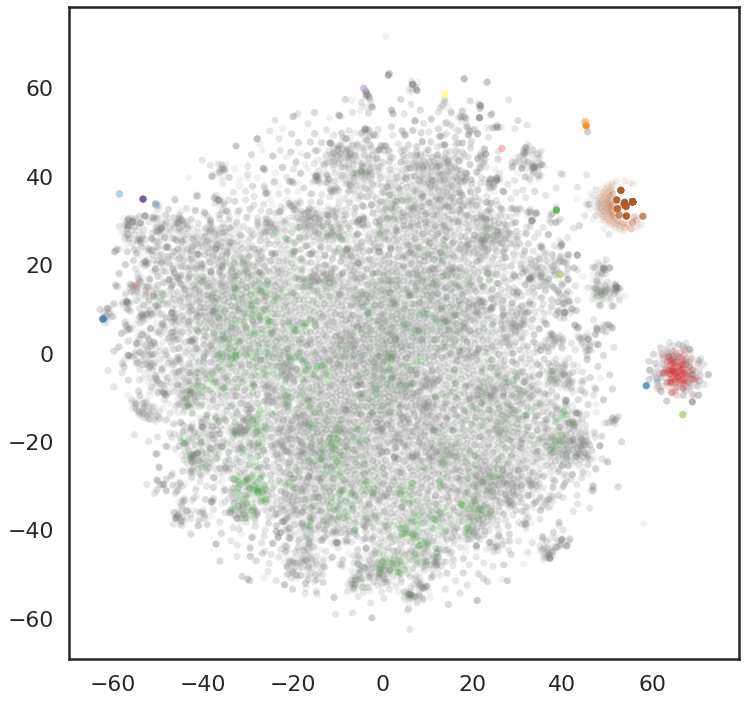

In [0]:
plt.figure(figsize=(12,12))
color_palette = sns.color_palette('Paired', 17)
cluster_colors = [color_palette[x] if x >= 0
else (0.5, 0.5, 0.5)
for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.1);

Let's see how it looks without the outliers removed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


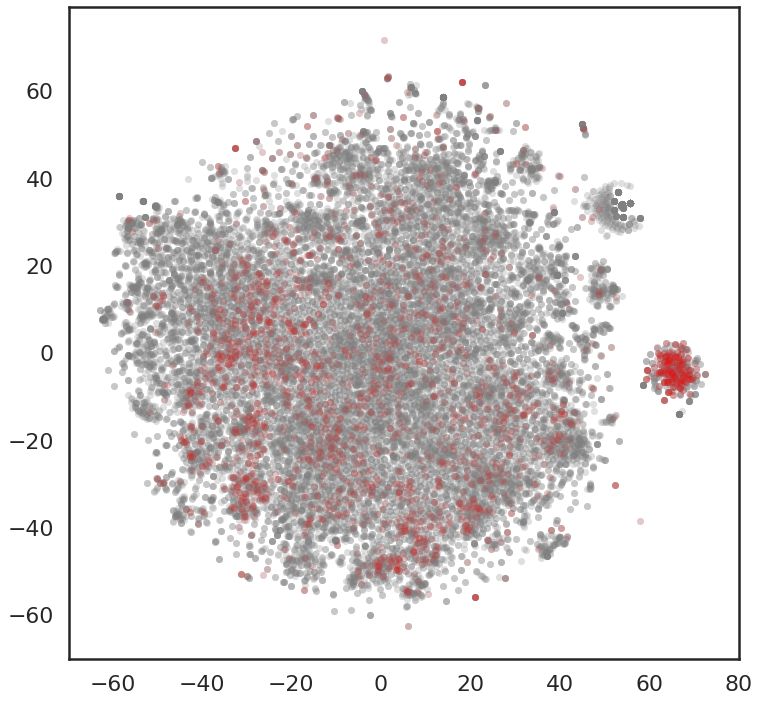

In [0]:
plt.figure(figsize=(12,12))
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*projection.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*projection[outliers].T, s=50, linewidth=0, c='red', alpha=0.1);

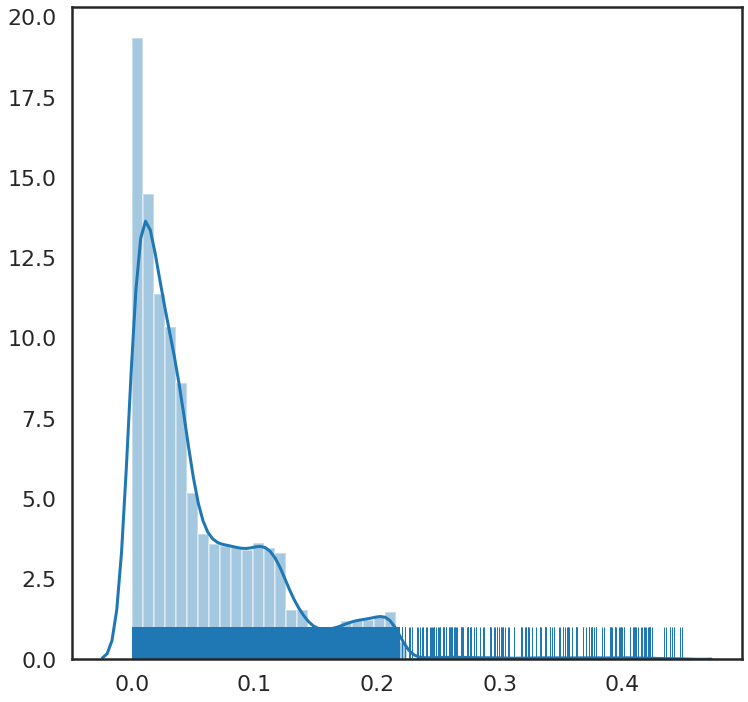

In [0]:
plt.figure(figsize=(12,12))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True);

Lets see if the softclusters are more visible.

/usr/local/lib/python3.6/dist-packages/hdbscan/prediction.py:547: RuntimeWarning: invalid value encountered in double_scalars
  clusterer.prediction_data_.cluster_tree)


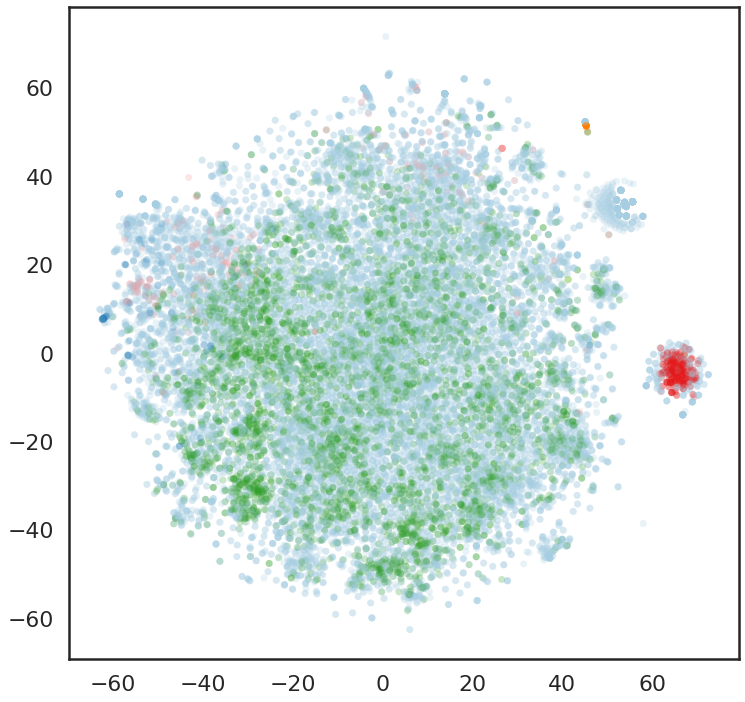

In [0]:
plt.figure(figsize=(12,12))
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
color_palette = sns.color_palette('Paired', 17)
cluster_colors = [color_palette[np.argmax(x)]  # cluster for which a given point has the highest probability of being in
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25);

## HDBSCAN condensed tree

Looking at the plot, we want to choose those clusters having the greatest area of ink in the plot.  

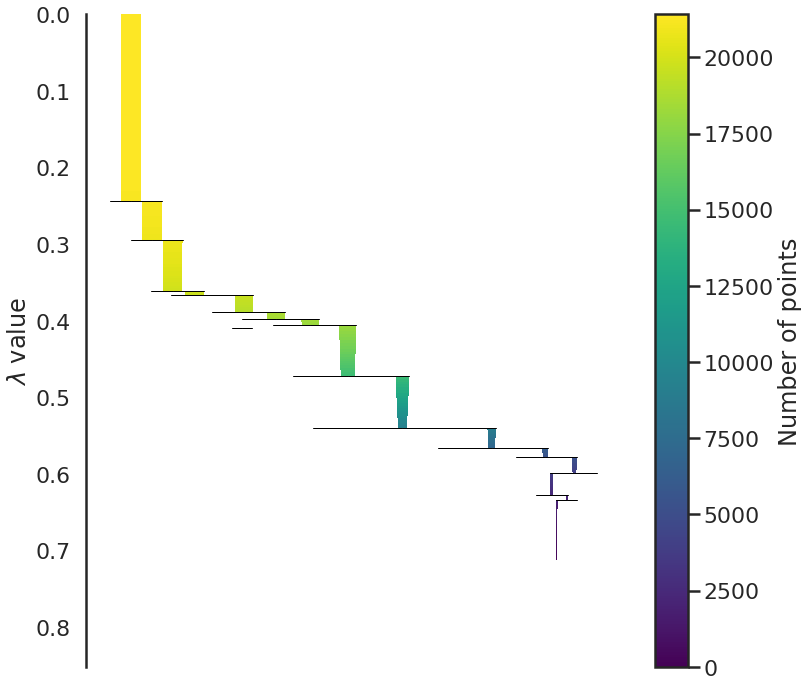

In [0]:
plt.figure(figsize=(12,12))
clusterer.condensed_tree_.plot();

/usr/local/lib/python3.6/dist-packages/hdbscan/plots.py:383: UserWarning: Infinite lambda values encountered in chosen clusters. This might be due to duplicates in the data.
  warn('Infinite lambda values encountered in chosen clusters.'


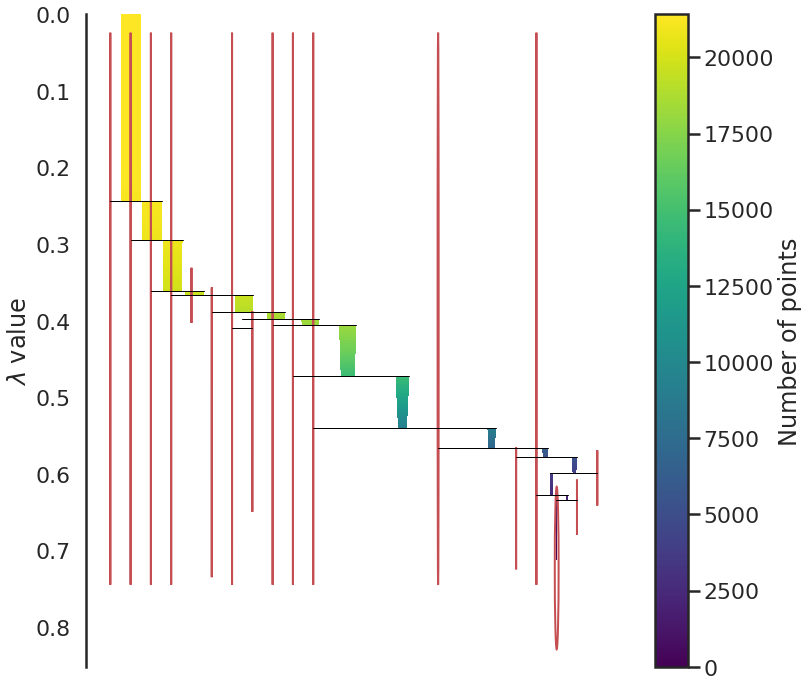

In [0]:
plt.figure(figsize=(12,12))
clusterer.condensed_tree_.plot(select_clusters=True
                            ,selection_palette=sns.color_palette());

In [0]:
palette= sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                 if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                 zip(clusterer.labels_,clusterer.probabilities_)]
plt.scatter(projection.T[0],projection.T[1], c=cluster_colors)

IndexError: ignored


## Tensorboard Projector Visualization
Visualization and clustering of high-dimensional data using TensorFlow backend.

In [48]:
tfc.disable_eager_execution()


In [97]:
X=G2['vector']
Y=G2['Actionable']

In [98]:
(len(G2['vector']))

20867

In [101]:
X.shape

(20867,)

In [102]:
embedding = np.empty((len(G2['vector']),G2['vector'][1].shape[0]), dtype = np.float32)
for i, vector in enumerate(G2['vector']):
    embedding[i] = vector
# Set up TensorFlow session
# tf.reset_default_graph()
sess=tf.InteractiveSession()
X = tf.Variable([0.0,1], name='embedding')
place = tfc.placeholder(tf.float32, shape=embedding.shape)
set_x = tf.assign(X, 
                   place,
                   validate_shape=False)
sess.run(tf.global_variables_initializer())
sess.run(set_x, feed_dict={place: embedding})


AttributeError: module 'tensorflow' has no attribute 'InteractiveSession'

In [0]:
# Create a TensorFlow summary writer
# summary_writer = tf.summary.FileWriter('/Users/allanshomefolder/GA/projects/Capstone/Code/log', sess.graph)    # For local host
summary_writer = tf.summary.FileWriter('/content/drive/My Drive/Colab Notebooks/Capstone/Capstone/Code/log', sess.graph)    # For Colab

config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
embedding_conf.tensor_name = 'embedding:0'
# embedding_conf.metadata_path = os.path.join('/Users/allanshomefolder/GA/projects/Capstone/Code/log', 'metadata.tsv')     # For local host
embedding_conf.metadata_path = os.path.join('/content/drive/My Drive/Colab Notebooks/Capstone/Capstone/Code/log', 'metadata.tsv')      # For Colab

projector.visualize_embeddings(summary_writer, config)


AttributeError: ignored

In [0]:
# Save the model
saver = tf.train.Saver()
# saver.save(sess, os.path.join('/Users/allanshomefolder/GA/projects/Capstone/Code/log', 'model.ckpt'))               # For local host
saver.save(sess, os.path.join('./log', 'model.ckpt'))   # For Colab

'/content/drive/My Drive/Colab Notebooks/Capstone/Capstone/Code/log/model.ckpt'

In [1]:
# notebook.display(port=6006, height=1000)
# use this first time
# %load_ext tensorboard  

# use this sebsequent reloads
# %reload_ext tensorboard
%tensorboard --logdir ./log

UsageError: Line magic function `%tensorboard` not found.
